In [15]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras import layers
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import talib as ta
from hmmlearn.hmm import GaussianHMM
from xgboost import XGBRegressor
import talib as ta
import yfinance as yf
import warnings
from sklearn.model_selection import KFold
warnings.filterwarnings("ignore")


In [20]:
print(tf.__version__)

2.16.1


In [16]:
data_original = yf.download("DTE", start="2022-01-01", end="2024-05-01", interval="1d")
data_original.sort_values('Date', inplace=True)
data_original = data_original[['Open', 'Close']]
data_original.dropna(inplace=True)
print(data_original.shape)


[*********************100%%**********************]  1 of 1 completed

(584, 2)


Model is not converging.  Current: 626.8669825321273 is not greater than 626.8811183168154. Delta is -0.014135784688164676


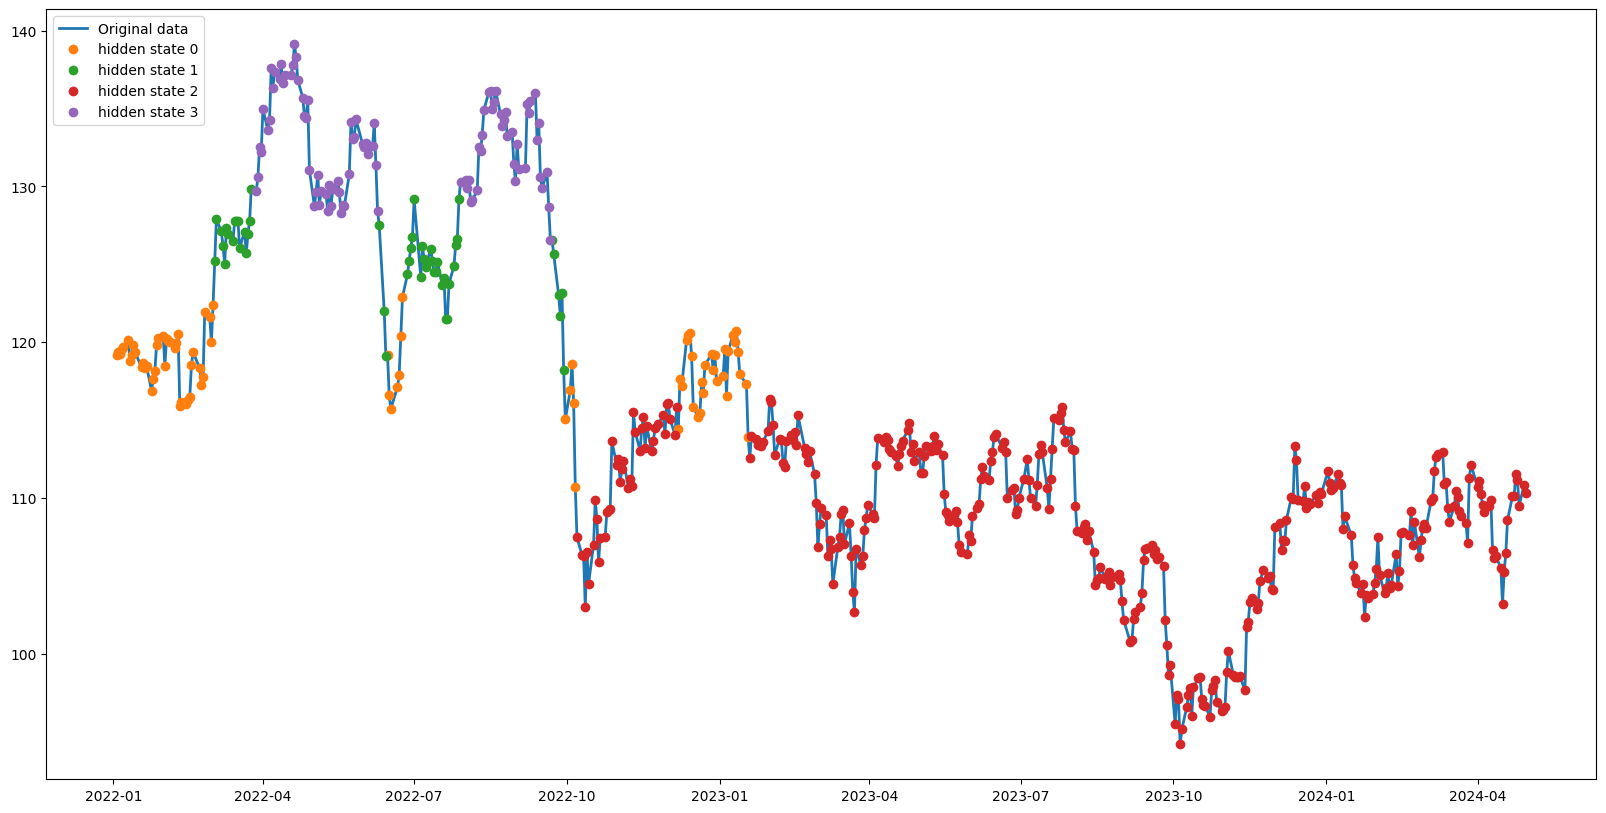

In [17]:
scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

scaled_features = scaler.fit_transform(data_original.drop('Close', axis=1))
scaled_target = target_scaler.fit_transform(data_original[['Close']])
scaled_data = pd.DataFrame(np.concatenate([scaled_features, scaled_target], axis=1), columns=list(data_original.drop('Close', axis=1).columns) + ['Close'])

X = scaled_data.drop(['Close'], axis=1)
y = scaled_data['Close']
hmm_model = GaussianHMM(n_components=4, covariance_type="spherical", n_iter=10000000000000000000)
hmm_model.fit(X)
hidden_states = hmm_model.predict(X)

#appending back to original data
data_original['hidden_states'] = hidden_states
#data_original['emission_prob_gmm'] = hmm_model.predict_proba(X).max(axis=1)

plt.figure(figsize=(20, 10))
plt.plot(data_original.index, data_original['Close'], lw=2, label='Original data')
for i in range(hmm_model.n_components):
    state = (hidden_states == i)
    plt.plot(data_original.index[state], data_original['Close'][state], 'o', label='hidden state %d' % i, lw=1.5)
    plt.legend(loc="upper left")
plt.show()

#### XGB

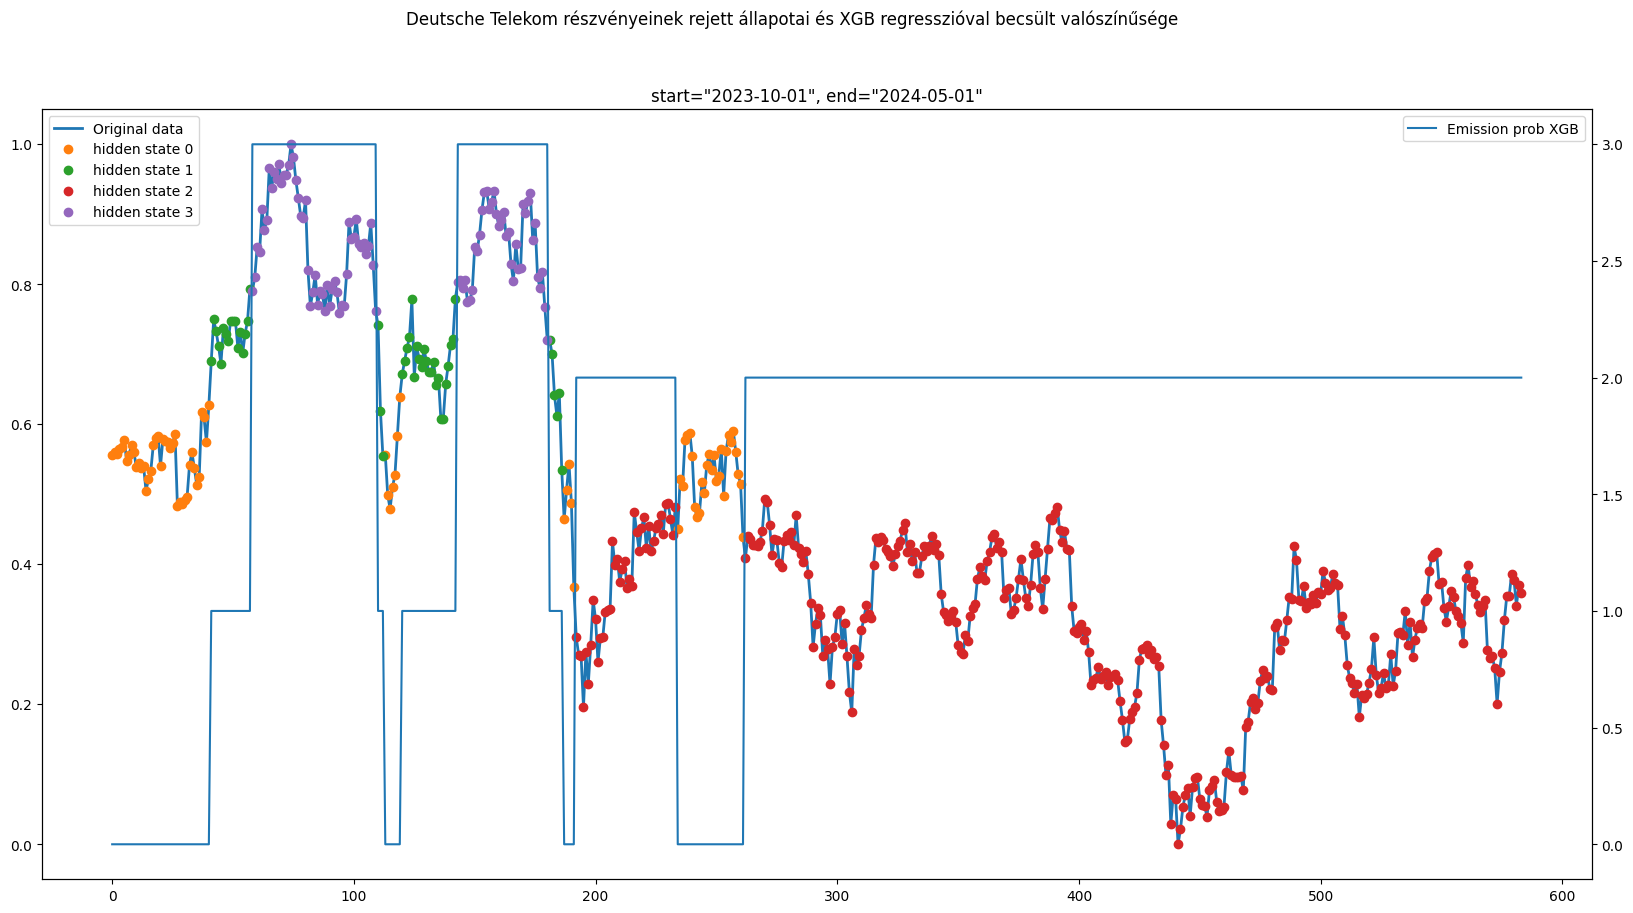

(560,) (20,)


KeyboardInterrupt: 

In [18]:
class LSTM(nn.Module):
    def __init__(self, hidden_layer_size=512):
        super().__init__()
        self.lstm_model = None
        self.hidden_layer_size = hidden_layer_size
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))
        #self.predict_scaler = MinMaxScaler()
        self.hmm_model = hmm_model
        self.xgb_model = None
        self.train_loader = None
        self.test_loader = None
        self.batch_size = 1
        self.lookback = 2
        self.scaler = scaler
        self.target_scaler = target_scaler
        self.hidden_states = hidden_states
    def prepare_sequences(self, data, lookback):
        X, y = [], []
        for i in range(len(data) - lookback - 1):
            X.append(data.iloc[i:i+lookback].values)
            y.append(data.iloc[i + lookback, 0])
        X = torch.tensor(np.array(X))
        y = torch.tensor(np.array(y))

        return X, y
    def lstm_input(self, data, lookback, mode, batch_size):
        if mode == 'train':
            scaled_data = self.feature_engineering(data, mode='train')
            # train-test split for time series
            train_size = int(len(scaled_data) * 0.65)
            train, test = scaled_data[:train_size], scaled_data[train_size:]

            X_train, y_train = self.prepare_sequences(train, lookback=lookback)
            X_test, y_test = self.prepare_sequences(test, lookback=lookback)
            
            # Create data loaders
            train_dataset = TensorDataset(X_train, y_train)
            test_dataset = TensorDataset(X_test, y_test)

            train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
            test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

            return train_loader, test_loader, scaled_data.shape[1], test, X_train, y_train, X_test, y_test

        elif mode == 'predict':
            scaled_data = self.feature_engineering(data, mode='predict')
            #preparing the dataset for model.predict()
            X, _ = self.prepare_sequences(scaled_data, lookback=lookback)
            dataset = DataLoader(dataset=X, batch_size=batch_size, shuffle=False)

            return scaled_data, dataset
    def feature_engineering(self, data, mode):
        data.columns = map(str.capitalize, data.columns)
        data = data.dropna()
        if mode == 'train':
            scaled_features = scaler.fit_transform(data.drop('Close', axis=1))
            scaled_target = target_scaler.fit_transform(data[['Close']])
            scaled_data = pd.DataFrame(np.concatenate([scaled_features, scaled_target], axis=1), columns=list(data.drop('Close', axis=1).columns) + ['Close'])

            X = scaled_data.drop(['Close'], axis=1)
            y = data['Hidden_states']
            self.model_xgb = XGBRegressor(n_estimators=50000, learning_rate=0.25)

            self.model_xgb.fit(X, y)
            self.model_xgb.score(X, y)

            emission_prob_xgb = self.model_xgb.predict(scaled_data.drop(['Close'], axis=1))

            #scaled_data['hidden_states'] = self.hidden_states
            scaled_data['emission_prob_XGB'] = emission_prob_xgb
            #scaled_data['emission_prob_hmm'] = hmm_model.predict_proba(X).max(axis=1)


            #plotting Close, hidden_states and emission_prob from scaled_data
            plt.figure(figsize=(20, 10))
            plt.plot(scaled_data.index, scaled_data['Close'], lw=2, label='Original data')
            plt.title('start="2023-10-01", end="2024-05-01"')
            plt.suptitle('Deutsche Telekom részvényeinek rejett állapotai és XGB regresszióval becsült valószínűsége')
            for i in range(self.hmm_model.n_components):
                state = (self.hidden_states == i)
                plt.plot(scaled_data.index[state], scaled_data['Close'][state], 'o', label='hidden state %d' % i, lw=1.5)
                plt.legend(loc="upper left")
            plt.twinx()
            plt.plot(scaled_data['emission_prob_XGB'], label='Emission prob XGB')
            plt.legend()
            plt.show()
            return scaled_data
        elif mode == 'predict':
            scaled_features = self.scaler.transform(data.drop('Close', axis=1))
            scaled_target = self.target_scaler.transform(data[['Close']])
            scaled_data = pd.DataFrame(np.concatenate([scaled_features, scaled_target], axis=1), columns=list(data.drop('Close', axis=1).columns) + ['Close'])

            X = scaled_data.drop(['Close'], axis=1)
            X = X.values.reshape(X.shape[0], X.shape[1])
            
            hidden_states = self.model_hmm.predict(X)
            emission_prob = self.model_xgb.predict(X)
            scaled_data['hidden_states'] = self.hidden_states
            scaled_data['emission_prob'] = emission_prob
        return scaled_data
    def train_lstm(self, data):
        batch_size = self.batch_size
        lookback = self.lookback
        self.train_loader, self.test_loader, input_shape, test = self.lstm_input(data, lookback=lookback, batch_size=batch_size, mode='train')
        self.lstm_model = Sequential([
            layers.LSTM(units=self.hidden_layer_size, return_sequences=True, input_shape=(lookback, input_shape), activation='relu'),
            layers.Dropout(0.4),
            layers.LSTM(units=256, activation='relu', return_sequences=True),
            layers.Dropout(0.3),
            layers.LSTM(units=128, activation='relu', return_sequences=False),
            layers.Dropout(0.2),
            layers.Dense(units=64),
            layers.Dropout(0.1),
            layers.Dense(units=1)
        ])
        
        optimizer = tf.keras.optimizers.AdamW(learning_rate=0.00003)
        
        self.lstm_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae','mape'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)
        self.lstm_model.fit(self.train_loader, epochs=100, batch_size=batch_size, validation_data=self.test_loader,
                            verbose=0, shuffle=False, callbacks=[early_stop])

        # plt.plot(self.lstm_model.history.history['loss'], label='train')
        # plt.plot(self.lstm_model.history.history['val_loss'], label='test')
        # plt.legend()
        # plt.show()
        #printing accuracy
        print('Mean Absolute Error:', self.lstm_model.history.history['mae'][-1])

        y_test, y_pred = self.evaluate_lstm(data)
        self.plot_predictions(y_test, y_pred)
        test = test.iloc[-len(y_pred):]
        test['predicted_close'] = y_pred
        test['predicted_movement'] = test['predicted_close'] - test['Close']
        test['predicted_binary_movement'] = np.where(test['predicted_movement'] > 0, 1, 0)

        return test, self.lsmt_model
    def evaluate_lstm(self, data):
        y_pred = self.lstm_model.predict(self.test_loader)
        y_pred = y_pred.reshape(-1, 1)  # added this line to reshape y_pred
        y_pred = self.target_scaler.inverse_transform(y_pred)
        y_test = data['Close'].values[-len(y_pred):].reshape(-1, 1)
        return y_test, y_pred   
    def plot_predictions(self, y_test, y_pred):
        plt.figure(figsize=(20, 10))
        #close vs predicted close
        plt.plot(y_test, label='Close')
        plt.plot(y_pred, label='Predicted Close')
        plt.title('Záróár vs becsült záróár')
        plt.suptitle('Deutsche Telekom részvényeinek záróára és LSTM modellel becsült záróára XGB módszerrel becsült valószínűsége alapján')
        plt.legend()
        plt.show()
    def make_predictions(self, data):
        scaled_data, dataset = self.lstm_input(data, lookback=self.lookback, mode='predict', batch_size=self.batch_size)
        predictions = []
        for batch in dataset:
            y_pred = self.lstm_model.predict(batch)
            predictions.extend(y_pred)
        predictions = np.array(predictions).reshape(-1, 1)
        
        #appending 
        predictions = self.target_scaler.inverse_transform(predictions)
        #Aligning length of predictions with the original data
        scaled_data = scaled_data.iloc[-len(predictions):]
        scaled_data['Close'] = self.target_scaler.inverse_transform(scaled_data[['Close']])
        scaled_data['predicted_close'] = predictions

        scaled_data['predicted_movement'] = scaled_data['predicted_close'] - scaled_data['Close']
        scaled_data['predicted_binary_movement'] = np.where(scaled_data['predicted_movement'] > 0, 1, 0)

        return scaled_data
XGB_Algo = LSTM()
#xgb_test,  xgb_model = XGB_Algo.train_lstm(data_original)


# Merge inputs and targets
train_loader, test_loader, input_shape, test, X_train, y_train, X_test, y_test  = XGB_Algo.lstm_input(data_original, 1, 'train', 1)

num_folds = 30

# Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=False)

# K-fold Cross Validation model evaluation
fold_no = 1
xgb_acc_per_fold = []
xgb_loss_per_fold = []

for train, test in kfold.split(inputs, targets):
    print(train.shape, test.shape)
    #convert to tensor
    train = TensorDataset(torch.tensor(inputs[train]), torch.tensor(targets[train]))
    test = TensorDataset(torch.tensor(inputs[test]), torch.tensor(targets[test]))
    train = DataLoader(dataset=train, batch_size=1, shuffle=False)
    test = DataLoader(dataset=test, batch_size=1, shuffle=False)

    xgb_lstm_model = Sequential([
    layers.LSTM(units=128, return_sequences=True, input_shape=(1, input_shape), activation='relu'),
    layers.Dropout(0.4),
    layers.LSTM(units=64, activation='relu', return_sequences=True),
    layers.Dropout(0.3),
    layers.LSTM(units=32, activation='relu', return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(units=16),
    layers.Dropout(0.1),
    layers.Dense(units=1)
])

    optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0005)

    xgb_lstm_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae','mape'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)
    history = xgb_lstm_model.fit(train, epochs=100, batch_size=1, validation_data=test,
                        verbose=0, shuffle=False, callbacks=[early_stop])


    scores = xgb_lstm_model.evaluate(test, verbose=0)
    print(f'Score for fold {fold_no}: {xgb_lstm_model.metrics_names[0]} of {scores[0]}; {xgb_lstm_model.metrics_names[1]} of {scores[1]*100}%')
    xgb_acc_per_fold.append(scores[1] * 100)
    xgb_loss_per_fold.append(scores[0])

#plotting each fold's predictions and actual values
    y_pred = xgb_lstm_model.predict(test_loader)
    y_pred = y_pred.reshape(-1, 1)  # added this line to reshape y_pred
    y_pred = target_scaler.inverse_transform(y_pred)
    y_test = data_original['Close'].values[-len(y_pred):].reshape(-1, 1)
    plt.figure(figsize=(20, 10))
    #close vs predicted close
    plt.plot(y_test, label='Close')
    plt.plot(y_pred, label='Predicted Close')
    plt.title(f'Záróár vs becsült záróár, {fold_no}. fold')
    plt.suptitle('XGB regresszióval becsült emissziós valószínűség alapján')
    plt.legend()
    plt.show()


    # Increase fold number
    fold_no = fold_no + 1


#### GMM

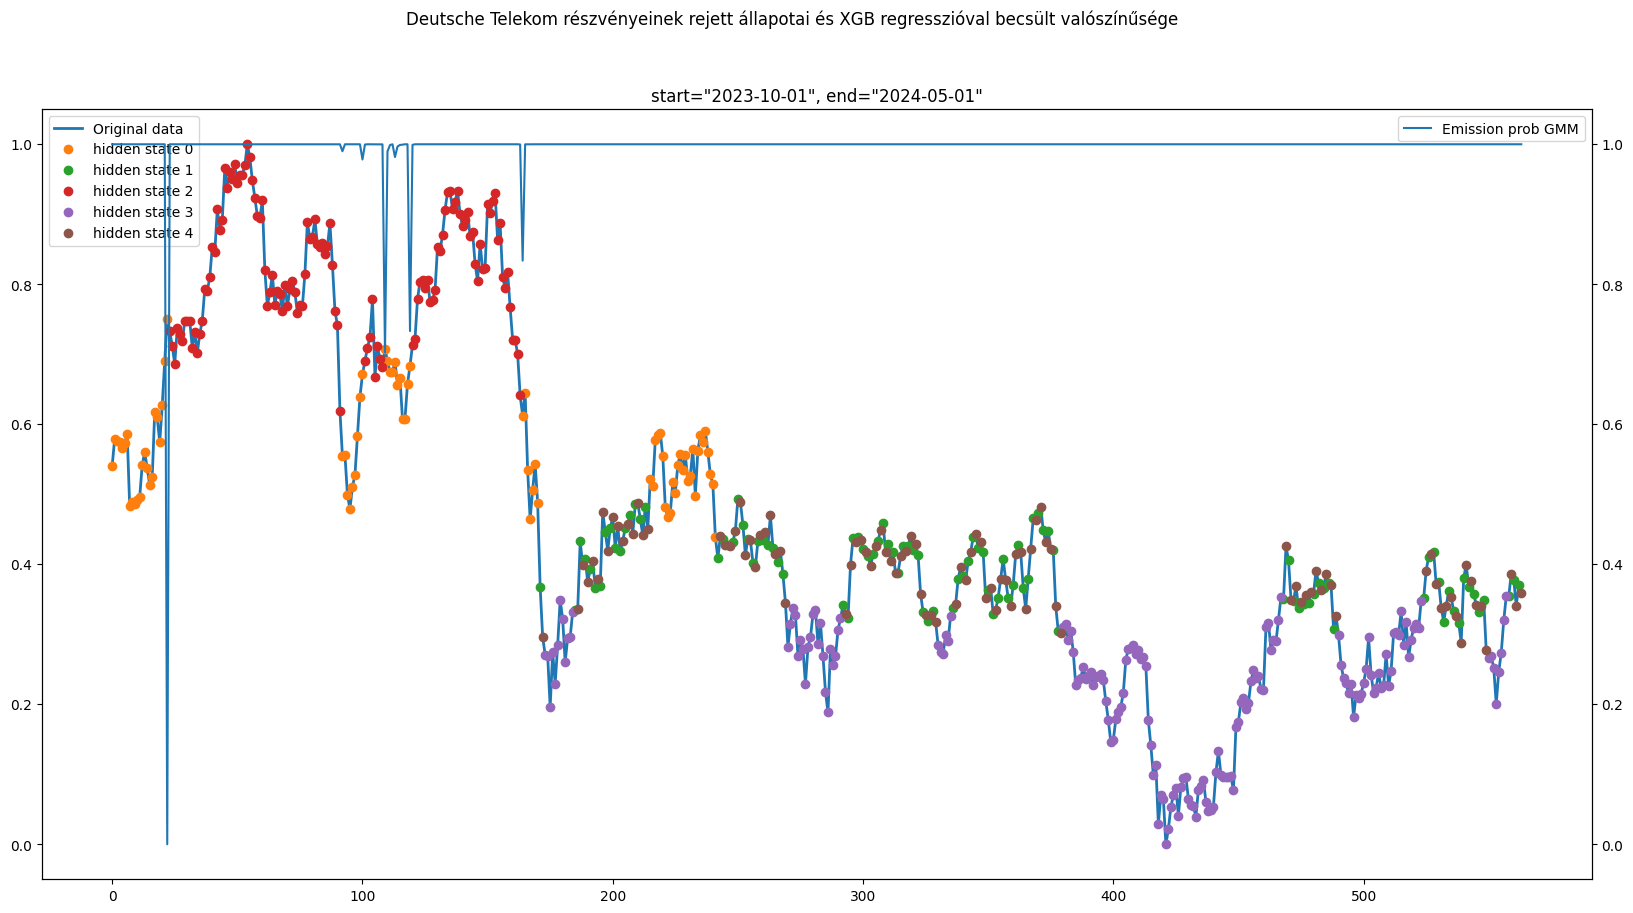

Score for fold 1: loss of 0.04878919944167137; compile_metrics of 19.39181536436081%
Score for fold 2: loss of 0.0334271676838398; compile_metrics of 16.961590945720673%
Score for fold 3: loss of 0.04890046641230583; compile_metrics of 21.12025022506714%
Score for fold 4: loss of 0.003813242306932807; compile_metrics of 4.80174720287323%
Score for fold 5: loss of 0.003118054708465934; compile_metrics of 4.722069948911667%
Score for fold 6: loss of 0.0033035425003618; compile_metrics of 4.904755204916%
Score for fold 7: loss of 0.003720668377354741; compile_metrics of 4.742780700325966%
Score for fold 8: loss of 0.0482671745121479; compile_metrics of 20.410262048244476%
Score for fold 9: loss of 0.006656057201325893; compile_metrics of 6.894732266664505%
Score for fold 10: loss of 0.00277418433688581; compile_metrics of 4.218906536698341%


In [ ]:
data_original['emission_prob_gmm'] = hmm_model.predict_proba(X).max(axis=1)
class LSTM(nn.Module):
    def __init__(self, hidden_layer_size=512):
        super().__init__()
        self.lstm_model = None
        self.hidden_layer_size = hidden_layer_size
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))
        #self.predict_scaler = MinMaxScaler()
        self.hmm_model = hmm_model
        self.xgb_model = None
        self.train_loader = None
        self.test_loader = None
        self.batch_size = 1
        self.lookback = 2
        self.scaler = scaler
        self.target_scaler = target_scaler
        self.hidden_states = hidden_states
    def prepare_sequences(self, data, lookback):
        X, y = [], []
        for i in range(len(data) - lookback - 1):
            X.append(data.iloc[i:i+lookback].values)
            y.append(data.iloc[i + lookback, 0])
        X = torch.tensor(np.array(X))
        y = torch.tensor(np.array(y))

        return X, y
    def lstm_input(self, data, lookback, mode, batch_size):
        if mode == 'train':
            scaled_data = self.feature_engineering(data, mode='train')
            # train-test split for time series
            train_size = int(len(scaled_data) * 0.65)
            train, test = scaled_data[:train_size], scaled_data[train_size:]

            X_train, y_train = self.prepare_sequences(train, lookback=lookback)
            X_test, y_test = self.prepare_sequences(test, lookback=lookback)
            
            # Create data loaders
            train_dataset = TensorDataset(X_train, y_train)
            test_dataset = TensorDataset(X_test, y_test)

            train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
            test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

            return train_loader, test_loader, scaled_data.shape[1], test, X_train, y_train, X_test, y_test

        elif mode == 'predict':
            scaled_data = self.feature_engineering(data, mode='predict')
            #preparing the dataset for model.predict()
            X, _ = self.prepare_sequences(scaled_data, lookback=lookback)
            dataset = DataLoader(dataset=X, batch_size=batch_size, shuffle=False)

            return scaled_data, dataset
    def feature_engineering(self, data, mode):
        data.columns = map(str.capitalize, data.columns)
        data = data.dropna()
        if mode == 'train':
            scaled_features = scaler.fit_transform(data.drop('Close', axis=1))
            scaled_target = target_scaler.fit_transform(data[['Close']])
            scaled_data = pd.DataFrame(np.concatenate([scaled_features, scaled_target], axis=1), columns=list(data.drop('Close', axis=1).columns) + ['Close'])
            # X = scaled_data.drop(['Close'], axis=1)
            # y = data['Hidden_states']
            # #getting the matching values for the hidden states

            # print('training XGB model')
            # self.model_xgb = XGBRegressor(n_estimators=50000, learning_rate=0.25)

            # self.model_xgb.fit(X, y)
            # self.model_xgb.score(X, y)

            # emission_prob_xgb = self.model_xgb.predict(scaled_data.drop(['Close'], axis=1))

            # #scaled_data['hidden_states'] = self.hidden_states
            # scaled_data['emission_prob_XGB'] = emission_prob_xgb
            #scaled_data['emission_prob_hmm'] = hmm_model.predict_proba(X).max(axis=1)


            #plotting Close, hidden_states and emission_prob from scaled_data
            plt.figure(figsize=(20, 10))
            plt.plot(scaled_data.index, scaled_data['Close'], lw=2, label='Original data')
            plt.title('start="2023-10-01", end="2024-05-01"')
            plt.suptitle('Deutsche Telekom részvényeinek rejett állapotai és XGB regresszióval becsült valószínűsége')
            for i in range(self.hmm_model.n_components):
                state = (self.hidden_states == i)
                plt.plot(scaled_data.index[state], scaled_data['Close'][state], 'o', label='hidden state %d' % i, lw=1.5)
                plt.legend(loc="upper left")
            plt.twinx()
            plt.plot(scaled_data['Emission_prob_gmm'], label='Emission prob GMM')
            plt.legend()
            plt.show()
            return scaled_data
        elif mode == 'predict':
            scaled_features = self.scaler.transform(data.drop('Close', axis=1))
            scaled_target = self.target_scaler.transform(data[['Close']])
            scaled_data = pd.DataFrame(np.concatenate([scaled_features, scaled_target], axis=1), columns=list(data.drop('Close', axis=1).columns) + ['Close'])

            X = scaled_data.drop(['Close'], axis=1)
            X = X.values.reshape(X.shape[0], X.shape[1])
            
            hidden_states = self.model_hmm.predict(X)
            emission_prob = self.model_xgb.predict(X)
            scaled_data['hidden_states'] = self.hidden_states
            scaled_data['emission_prob'] = emission_prob
        return scaled_data
    def train_lstm(self, data):
        batch_size = self.batch_size
        lookback = self.lookback
        self.train_loader, self.test_loader, input_shape, test = self.lstm_input(data, lookback=lookback, batch_size=batch_size, mode='train')
        self.lstm_model = Sequential([
            layers.LSTM(units=self.hidden_layer_size, return_sequences=True, input_shape=(lookback, input_shape), activation='relu'),
            layers.Dropout(0.4),
            layers.LSTM(units=256, activation='relu', return_sequences=True),
            layers.Dropout(0.3),
            layers.LSTM(units=128, activation='relu', return_sequences=False),
            layers.Dropout(0.2),
            layers.Dense(units=64),
            layers.Dropout(0.1),
            layers.Dense(units=1)
        ])
        
        optimizer = tf.keras.optimizers.AdamW(learning_rate=0.00003)
        
        self.lstm_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae','mape'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)
        self.lstm_model.fit(self.train_loader, epochs=100, batch_size=batch_size, validation_data=self.test_loader,
                            verbose=0, shuffle=False, callbacks=[early_stop])

        # plt.plot(self.lstm_model.history.history['loss'], label='train')
        # plt.plot(self.lstm_model.history.history['val_loss'], label='test')
        # plt.legend()
        # plt.show()
        print('Mean Absolute Error:', self.lstm_model.history.history['mae'][-1])

        y_test, y_pred = self.evaluate_lstm(data)
        self.plot_predictions(y_test, y_pred)

        return test, self.lstm_model
    def evaluate_lstm(self, data):
        y_pred = self.lstm_model.predict(self.test_loader)
        y_pred = y_pred.reshape(-1, 1)  # added this line to reshape y_pred
        y_pred = self.target_scaler.inverse_transform(y_pred)
        y_test = data['Close'].values[-len(y_pred):].reshape(-1, 1)
        return y_test, y_pred   
    def plot_predictions(self, y_test, y_pred):
        plt.figure(figsize=(20, 10))
        #close vs predicted close
        plt.plot(y_test, label='Close')
        plt.plot(y_pred, label='Predicted Close')
        plt.title('Záróár vs becsült záróár')
        plt.suptitle('Deutsche Telekom részvényeinek záróára és LSTM modellel becsült záróára GMM módszerrel becsült valószínűsége alapján')
    def make_predictions(self, data):
        scaled_data, dataset = self.lstm_input(data, lookback=self.lookback, mode='predict', batch_size=self.batch_size)
        predictions = []
        for batch in dataset:
            y_pred = self.lstm_model.predict(batch)
            predictions.extend(y_pred)
        predictions = np.array(predictions).reshape(-1, 1)
        
        #appending 
        predictions = self.target_scaler.inverse_transform(predictions)
        #Aligning length of predictions with the original data
        scaled_data = scaled_data.iloc[-len(predictions):]
        scaled_data['Close'] = self.target_scaler.inverse_transform(scaled_data[['Close']])
        scaled_data['predicted_close'] = predictions

        scaled_data['predicted_movement'] = scaled_data['predicted_close'] - scaled_data['Close']
        scaled_data['predicted_binary_movement'] = np.where(scaled_data['predicted_movement'] > 0, 1, 0)

        return scaled_data
GMM_Algo = LSTM()
#gmm_test, gmm_model = GMM_Algo.train_lstm(data_original)

# Merge inputs and targets
train_loader, test_loader, input_shape, test, X_train, y_train, X_test, y_test  = GMM_Algo.lstm_input(data_original, 1, 'train', 1)

num_folds = 30

# Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=False)

# K-fold Cross Validation model evaluation
fold_no = 1
xgb_acc_per_fold = []
xgb_loss_per_fold = []

for train, test in kfold.split(inputs, targets):
    print(train.shape, test.shape)
    #convert to tensor
    train = TensorDataset(torch.tensor(inputs[train]), torch.tensor(targets[train]))
    test = TensorDataset(torch.tensor(inputs[test]), torch.tensor(targets[test]))
    train = DataLoader(dataset=train, batch_size=1, shuffle=False)
    test = DataLoader(dataset=test, batch_size=1, shuffle=False)

    xgb_lstm_model = Sequential([
    layers.LSTM(units=128, return_sequences=True, input_shape=(1, input_shape), activation='relu'),
    layers.Dropout(0.4),
    layers.LSTM(units=64, activation='relu', return_sequences=True),
    layers.Dropout(0.3),
    layers.LSTM(units=32, activation='relu', return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(units=16),
    layers.Dropout(0.1),
    layers.Dense(units=1)
])

    optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0005)

    xgb_lstm_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae','mape'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)
    history = xgb_lstm_model.fit(train, epochs=100, batch_size=1, validation_data=test,
                        verbose=0, shuffle=False, callbacks=[early_stop])


    scores = xgb_lstm_model.evaluate(test, verbose=0)
    print(f'Score for fold {fold_no}: {xgb_lstm_model.metrics_names[0]} of {scores[0]}; {xgb_lstm_model.metrics_names[1]} of {scores[1]*100}%')
    xgb_acc_per_fold.append(scores[1] * 100)
    xgb_loss_per_fold.append(scores[0])

#plotting each fold's predictions and actual values
    y_pred = xgb_lstm_model.predict(test_loader)
    y_pred = y_pred.reshape(-1, 1)  # added this line to reshape y_pred
    y_pred = target_scaler.inverse_transform(y_pred)
    y_test = data_original['Close'].values[-len(y_pred):].reshape(-1, 1)
    plt.figure(figsize=(20, 10))
    #close vs predicted close
    plt.plot(y_test, label='Close')
    plt.plot(y_pred, label='Predicted Close')
    plt.title(f'Záróár vs becsült záróár, {fold_no}. fold')
    plt.suptitle('GMM módszerrel becsült emissziós valószínűség alapján')
    plt.legend()
    plt.show()


    # Increase fold number
    fold_no = fold_no + 1


#### GMM + XGB

In [ ]:
class LSTM(nn.Module):
    def __init__(self, hidden_layer_size=512):
        super().__init__()
        self.lstm_model = None
        self.hidden_layer_size = hidden_layer_size
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))
        #self.predict_scaler = MinMaxScaler()
        self.hmm_model = hmm_model
        self.xgb_model = None
        self.train_loader = None
        self.test_loader = None
        self.batch_size = 1
        self.lookback = 2
        self.scaler = scaler
        self.target_scaler = target_scaler
        self.hidden_states = hidden_states
    def prepare_sequences(self, data, lookback):
        X, y = [], []
        for i in range(len(data) - lookback - 1):
            X.append(data.iloc[i:i+lookback].values)
            y.append(data.iloc[i + lookback, 0])
        X = torch.tensor(np.array(X))
        y = torch.tensor(np.array(y))

        return X, y
    def lstm_input(self, data, lookback, mode, batch_size):
        if mode == 'train':
            scaled_data = self.feature_engineering(data, mode='train')
            # train-test split for time series
            train_size = int(len(scaled_data) * 0.65)
            train, test = scaled_data[:train_size], scaled_data[train_size:]

            X_train, y_train = self.prepare_sequences(train, lookback=lookback)
            X_test, y_test = self.prepare_sequences(test, lookback=lookback)
            
            # Create data loaders
            train_dataset = TensorDataset(X_train, y_train)
            test_dataset = TensorDataset(X_test, y_test)

            train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
            test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

            return train_loader, test_loader, scaled_data.shape[1], test, X_train, y_train, X_test, y_test

        elif mode == 'predict':
            scaled_data = self.feature_engineering(data, mode='predict')
            #preparing the dataset for model.predict()
            X, _ = self.prepare_sequences(scaled_data, lookback=lookback)
            dataset = DataLoader(dataset=X, batch_size=batch_size, shuffle=False)

            return scaled_data, dataset
    def feature_engineering(self, data, mode):
        data.columns = map(str.capitalize, data.columns)
        data = data.dropna()
        if mode == 'train':
            scaled_features = scaler.fit_transform(data.drop('Close', axis=1))
            scaled_target = target_scaler.fit_transform(data[['Close']])
            scaled_data = pd.DataFrame(np.concatenate([scaled_features, scaled_target], axis=1), columns=list(data.drop('Close', axis=1).columns) + ['Close'])
            X = scaled_data.drop(['Close'], axis=1)
            y = data['Hidden_states']
            # #getting the matching values for the hidden states

            # print('training XGB model')
            self.model_xgb = XGBRegressor(n_estimators=50000, learning_rate=0.25)
            self.model_xgb.fit(X, y)
            self.model_xgb.score(X, y)
            emission_prob_xgb = self.model_xgb.predict(scaled_data.drop(['Close'], axis=1))

            # #scaled_data['hidden_states'] = self.hidden_states
            scaled_data['emission_prob_XGB'] = emission_prob_xgb
            #scaled_data['emission_prob_hmm'] = hmm_model.predict_proba(X).max(axis=1)

            # #plotting Close, hidden_states and emission_prob from scaled_data
            # plt.figure(figsize=(20, 10))
            # plt.plot(scaled_data.index, scaled_data['Close'], lw=2, label='Original data')
            # plt.title('start="2023-10-01", end="2024-05-01"')
            # plt.suptitle('Deutsche Telekom részvényeinek rejett állapotai és XGB regresszióval becsült valószínűsége')
            # for i in range(self.hmm_model.n_components):
            #     state = (self.hidden_states == i)
            #     plt.plot(scaled_data.index[state], scaled_data['Close'][state], 'o', label='hidden state %d' % i, lw=1.5)
            #     plt.legend(loc="upper left")
            # plt.twinx()
            # plt.plot(scaled_data['Emission_prob_gmm'], label='Emission prob GMM')
            # plt.legend()
            # plt.show()
            return scaled_data
        
        elif mode == 'predict':
            scaled_features = self.scaler.transform(data.drop('Close', axis=1))
            scaled_target = self.target_scaler.transform(data[['Close']])
            scaled_data = pd.DataFrame(np.concatenate([scaled_features, scaled_target], axis=1), columns=list(data.drop('Close', axis=1).columns) + ['Close'])

            X = scaled_data.drop(['Close'], axis=1)
            X = X.values.reshape(X.shape[0], X.shape[1])
            
            hidden_states = self.model_hmm.predict(X)
            emission_prob = self.model_xgb.predict(X)
            scaled_data['hidden_states'] = self.hidden_states
            scaled_data['emission_prob'] = emission_prob
        return scaled_data
    def train_lstm(self, data):
        batch_size = self.batch_size
        lookback = self.lookback
        self.train_loader, self.test_loader, input_shape, test = self.lstm_input(data, lookback=lookback, batch_size=batch_size, mode='train')
        self.lstm_model = Sequential([
            layers.LSTM(units=self.hidden_layer_size, return_sequences=True, input_shape=(lookback, input_shape), activation='relu'),
            layers.Dropout(0.4),
            layers.LSTM(units=256, activation='relu', return_sequences=True),
            layers.Dropout(0.3),
            layers.LSTM(units=128, activation='relu', return_sequences=False),
            layers.Dropout(0.2),
            layers.Dense(units=64),
            layers.Dropout(0.1),
            layers.Dense(units=1)
        ])
        
        optimizer = tf.keras.optimizers.AdamW(learning_rate=0.00003)
        
        self.lstm_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae','mape'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)
        self.lstm_model.fit(self.train_loader, epochs=100, batch_size=batch_size, validation_data=self.test_loader,
                            verbose=0, shuffle=False, callbacks=[early_stop])

        # plt.plot(self.lstm_model.history.history['loss'], label='train')
        # plt.plot(self.lstm_model.history.history['val_loss'], label='test')
        # plt.legend()
        # plt.show()
        print('Mean Absolute Error:', self.lstm_model.history.history['mae'][-1])

        y_test, y_pred = self.evaluate_lstm(data)
        self.plot_predictions(y_test, y_pred)
        return test, self.lsmt_model
    def evaluate_lstm(self, data):
        y_pred = self.lstm_model.predict(self.test_loader)
        y_pred = y_pred.reshape(-1, 1)  # added this line to reshape y_pred
        y_pred = self.target_scaler.inverse_transform(y_pred)
        y_test = data['Close'].values[-len(y_pred):].reshape(-1, 1)
        return y_test, y_pred   
    def plot_predictions(self, y_test, y_pred):
        plt.figure(figsize=(20, 10))
        #close vs predicted close
        plt.plot(y_test, label='Close')
        plt.plot(y_pred, label='Predicted Close')
        plt.title('Záróár vs becsült záróár')
        plt.suptitle('Deutsche Telekom részvényeinek záróára és LSTM modellel becsült záróára XGB + GMM módszerrel becsült valószínűsége alapján')
        plt.legend()
        plt.show()
    def make_predictions(self, data):
        scaled_data, dataset = self.lstm_input(data, lookback=self.lookback, mode='predict', batch_size=self.batch_size)
        predictions = []
        for batch in dataset:
            y_pred = self.lstm_model.predict(batch)
            predictions.extend(y_pred)
        predictions = np.array(predictions).reshape(-1, 1)
        
        #appending 
        predictions = self.target_scaler.inverse_transform(predictions)
        #Aligning length of predictions with the original data
        scaled_data = scaled_data.iloc[-len(predictions):]
        scaled_data['Close'] = self.target_scaler.inverse_transform(scaled_data[['Close']])
        scaled_data['predicted_close'] = predictions

        scaled_data['predicted_movement'] = scaled_data['predicted_close'] - scaled_data['Close']
        scaled_data['predicted_binary_movement'] = np.where(scaled_data['predicted_movement'] > 0, 1, 0)

        return scaled_data
GMM_XGB_Algo = LSTM()
#gmm_xgb_test, gmm_xgb_model = GMM_XGB_Algo.train_lstm(data_original)

# Merge inputs and targets
train_loader, test_loader, input_shape, test, X_train, y_train, X_test, y_test  = GMM_XGB_Algo.lstm_input(data_original, 1, 'train', 1)


num_folds = 30

# Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=False)

# K-fold Cross Validation model evaluation
fold_no = 1
xgb_acc_per_fold = []
xgb_loss_per_fold = []

for train, test in kfold.split(inputs, targets):
    print(train.shape, test.shape)
    #convert to tensor
    train = TensorDataset(torch.tensor(inputs[train]), torch.tensor(targets[train]))
    test = TensorDataset(torch.tensor(inputs[test]), torch.tensor(targets[test]))
    train = DataLoader(dataset=train, batch_size=1, shuffle=False)
    test = DataLoader(dataset=test, batch_size=1, shuffle=False)

    xgb_lstm_model = Sequential([
    layers.LSTM(units=128, return_sequences=True, input_shape=(1, input_shape), activation='relu'),
    layers.Dropout(0.4),
    layers.LSTM(units=64, activation='relu', return_sequences=True),
    layers.Dropout(0.3),
    layers.LSTM(units=32, activation='relu', return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(units=16),
    layers.Dropout(0.1),
    layers.Dense(units=1)
])

    optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0005)

    xgb_lstm_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae','mape'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)
    history = xgb_lstm_model.fit(train, epochs=100, batch_size=1, validation_data=test,
                        verbose=0, shuffle=False, callbacks=[early_stop])


    scores = xgb_lstm_model.evaluate(test, verbose=0)
    print(f'Score for fold {fold_no}: {xgb_lstm_model.metrics_names[0]} of {scores[0]}; {xgb_lstm_model.metrics_names[1]} of {scores[1]*100}%')
    xgb_acc_per_fold.append(scores[1] * 100)
    xgb_loss_per_fold.append(scores[0])

#plotting each fold's predictions and actual values
    y_pred = xgb_lstm_model.predict(test_loader)
    y_pred = y_pred.reshape(-1, 1)  # added this line to reshape y_pred
    y_pred = target_scaler.inverse_transform(y_pred)
    y_test = data_original['Close'].values[-len(y_pred):].reshape(-1, 1)
    plt.figure(figsize=(20, 10))
    #close vs predicted close
    plt.plot(y_test, label='Close')
    plt.plot(y_pred, label='Predicted Close')
    plt.title(f'Záróár vs becsült záróár, {fold_no}. fold')
    plt.suptitle('GMM + XGB regresszióval becsült emissziós valószínűség alapján')
    plt.legend()
    plt.show()


    # Increase fold number
    fold_no = fold_no + 1




Score for fold 1: loss of 0.07893402129411697; compile_metrics of 24.739602208137512%
Score for fold 2: loss of 0.07409043610095978; compile_metrics of 25.614556670188904%
Score for fold 3: loss of 0.09421718120574951; compile_metrics of 29.365533590316772%
Score for fold 4: loss of 0.0053286380134522915; compile_metrics of 6.016146019101143%
Score for fold 5: loss of 0.005295227747410536; compile_metrics of 6.208065524697304%
Score for fold 6: loss of 0.0033447586465626955; compile_metrics of 4.715443402528763%
Score for fold 7: loss of 0.003873151959851384; compile_metrics of 4.9488842487335205%
Score for fold 8: loss of 0.048203758895397186; compile_metrics of 20.396791398525238%
Score for fold 9: loss of 0.0069833844900131226; compile_metrics of 7.255401462316513%
Score for fold 10: loss of 0.0028714186046272516; compile_metrics of 4.516749456524849%


#### REFERENCE

In [ ]:
class LSTM(nn.Module):
    def __init__(self, hidden_layer_size=256):
        super().__init__()
        self.lstm_model = None
        self.hidden_layer_size = hidden_layer_size
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))
        #self.predict_scaler = MinMaxScaler()
        self.hmm_model = hmm_model
        self.xgb_model = None
        self.train_loader = None
        self.test_loader = None
        self.batch_size = 1
        self.lookback = 2
        self.scaler = scaler
        self.target_scaler = target_scaler
        self.hidden_states = hidden_states
    def prepare_sequences(self, data, lookback):
        X, y = [], []
        for i in range(len(data) - lookback - 1):
            X.append(data.iloc[i:i+lookback].values)
            y.append(data.iloc[i + lookback, 0])
        X = torch.tensor(np.array(X))
        y = torch.tensor(np.array(y))

        return X, y
    def lstm_input(self, data, lookback, mode, batch_size):
        if mode == 'train':
            scaled_data = self.feature_engineering(data, mode='train')
            # train-test split for time series
            train_size = int(len(scaled_data) * 0.65)
            train, test = scaled_data[:train_size], scaled_data[train_size:]

            X_train, y_train = self.prepare_sequences(train, lookback=lookback)
            X_test, y_test = self.prepare_sequences(test, lookback=lookback)
            
            # Create data loaders
            train_dataset = TensorDataset(X_train, y_train)
            test_dataset = TensorDataset(X_test, y_test)

            train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
            test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

            return train_loader, test_loader, scaled_data.shape[1], test, X_train, y_train, X_test, y_test

        elif mode == 'predict':
            scaled_data = self.feature_engineering(data, mode='predict')
            #preparing the dataset for model.predict()
            X, _ = self.prepare_sequences(scaled_data, lookback=lookback)
            dataset = DataLoader(dataset=X, batch_size=batch_size, shuffle=False)

            return scaled_data, dataset
        
    def feature_engineering(self, data, mode):
        data.columns = map(str.capitalize, data.columns)
        data = data.dropna()

        if mode == 'train':
            scaled_features = scaler.fit_transform(data.drop('Close', axis=1))
            scaled_target = target_scaler.fit_transform(data[['Close']])
            scaled_data = pd.DataFrame(np.concatenate([scaled_features, scaled_target], axis=1), columns=list(data.drop('Close', axis=1).columns) + ['Close'])
            
            # dropping 'Hidden_states', 'Emission_prob_gmm'
            scaled_data = scaled_data.drop(['Hidden_states', 'Emission_prob_gmm'], axis=1)
            print(scaled_data.columns)
            return scaled_data
        elif mode == 'predict':
            scaled_features = self.scaler.transform(data.drop('Close', axis=1))
            scaled_target = self.target_scaler.transform(data[['Close']])
            scaled_data = pd.DataFrame(np.concatenate([scaled_features, scaled_target], axis=1), columns=list(data.drop('Close', axis=1).columns) + ['Close'])

            X = scaled_data.drop(['Close'], axis=1)
            X = X.values.reshape(X.shape[0], X.shape[1])
            
            hidden_states = self.model_hmm.predict(X)
            emission_prob = self.model_xgb.predict(X)
            scaled_data['hidden_states'] = self.hidden_states
            scaled_data['emission_prob'] = emission_prob
        return scaled_data
    
    def train_lstm(self, data):
        batch_size = self.batch_size
        lookback = self.lookback
        self.train_loader, self.test_loader, input_shape, test, X_train, y_train, X_test, y_test = self.lstm_input(data, lookback=lookback, batch_size=batch_size, mode='train')
        
        
        self.lstm_model = Sequential([
            layers.LSTM(units=self.hidden_layer_size, return_sequences=True, input_shape=(lookback, input_shape), activation='relu'),
            layers.Dropout(0.4),
            layers.LSTM(units=256, activation='relu', return_sequences=True),
            layers.Dropout(0.3),
            layers.LSTM(units=128, activation='relu', return_sequences=False),
            layers.Dropout(0.2),
            layers.Dense(units=64),
            layers.Dropout(0.1),
            layers.Dense(units=1)
        ])
        
        optimizer = tf.keras.optimizers.AdamW(learning_rate=0.00003)
        
        self.lstm_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae','mape'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)
        self.lstm_model.fit(self.train_loader, epochs=100, batch_size=batch_size, validation_data=self.test_loader,
                            verbose=0, shuffle=False, callbacks=[early_stop])

        # plt.plot(self.lstm_model.history.history['loss'], label='train')
        # plt.plot(self.lstm_model.history.history['val_loss'], label='test')
        # plt.legend()
        # plt.show()
        print('Mean Absolute Error:', self.lstm_model.history.history['mae'][-1])

        y_test, y_pred = self.evaluate_lstm(data)
        self.plot_predictions(y_test, y_pred)
        return test
    def evaluate_lstm(self, data):
        y_pred = self.lstm_model.predict(self.test_loader)
        y_pred = y_pred.reshape(-1, 1)  # added this line to reshape y_pred
        y_pred = self.target_scaler.inverse_transform(y_pred)
        y_test = data['Close'].values[-len(y_pred):].reshape(-1, 1)
        return y_test, y_pred   
    def plot_predictions(self, y_test, y_pred):
        plt.figure(figsize=(20, 10))
        #close vs predicted close
        plt.plot(y_test, label='Close')
        plt.plot(y_pred, label='Predicted Close')
        plt.title('Záróár vs becsült záróár')
        plt.suptitle('Deutsche Telekom részvényeinek záróára és LSTM modellel (Referencia)')
        plt.show()
    def make_predictions(self, data):
        scaled_data, dataset = self.lstm_input(data, lookback=self.lookback, mode='predict', batch_size=self.batch_size)
        predictions = []
        for batch in dataset:
            y_pred = self.lstm_model.predict(batch)
            predictions.extend(y_pred)
        predictions = np.array(predictions).reshape(-1, 1)
        
        #appending 
        predictions = self.target_scaler.inverse_transform(predictions)
        #Aligning length of predictions with the original data
        scaled_data = scaled_data.iloc[-len(predictions):]
        scaled_data['Close'] = self.target_scaler.inverse_transform(scaled_data[['Close']])
        scaled_data['predicted_close'] = predictions

        scaled_data['predicted_movement'] = scaled_data['predicted_close'] - scaled_data['Close']
        scaled_data['predicted_binary_movement'] = np.where(scaled_data['predicted_movement'] > 0, 1, 0)

        return scaled_data
ReferenceAlgo = LSTM()
#reference_test, reference_model = ReferenceAlgo.train_lstm(data_original)

# Merge inputs and targets
train_loader, test_loader, input_shape, test, X_train, y_train, X_test, y_test  = ReferenceAlgo.lstm_input(data_original, 1, 'train', 1)

num_folds = 30

# Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=False)

# K-fold Cross Validation model evaluation
fold_no = 1
xgb_acc_per_fold = []
xgb_loss_per_fold = []

for train, test in kfold.split(inputs, targets):
    print(train.shape, test.shape)
    #convert to tensor
    train = TensorDataset(torch.tensor(inputs[train]), torch.tensor(targets[train]))
    test = TensorDataset(torch.tensor(inputs[test]), torch.tensor(targets[test]))
    train = DataLoader(dataset=train, batch_size=1, shuffle=False)
    test = DataLoader(dataset=test, batch_size=1, shuffle=False)

    xgb_lstm_model = Sequential([
    layers.LSTM(units=128, return_sequences=True, input_shape=(1, input_shape), activation='relu'),
    layers.Dropout(0.4),
    layers.LSTM(units=64, activation='relu', return_sequences=True),
    layers.Dropout(0.3),
    layers.LSTM(units=32, activation='relu', return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(units=16),
    layers.Dropout(0.1),
    layers.Dense(units=1)
])

    optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0005)

    xgb_lstm_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae','mape'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)
    history = xgb_lstm_model.fit(train, epochs=100, batch_size=1, validation_data=test,
                        verbose=0, shuffle=False, callbacks=[early_stop])


    scores = xgb_lstm_model.evaluate(test, verbose=0)
    print(f'Score for fold {fold_no}: {xgb_lstm_model.metrics_names[0]} of {scores[0]}; {xgb_lstm_model.metrics_names[1]} of {scores[1]*100}%')
    xgb_acc_per_fold.append(scores[1] * 100)
    xgb_loss_per_fold.append(scores[0])

#plotting each fold's predictions and actual values
    y_pred = xgb_lstm_model.predict(test_loader)
    y_pred = y_pred.reshape(-1, 1)  # added this line to reshape y_pred
    y_pred = target_scaler.inverse_transform(y_pred)
    y_test = data_original['Close'].values[-len(y_pred):].reshape(-1, 1)
    plt.figure(figsize=(20, 10))
    #close vs predicted close
    plt.plot(y_test, label='Close')
    plt.plot(y_pred, label='Predicted Close')
    plt.title(f'Záróár vs becsült záróár, {fold_no}. fold')
    plt.suptitle('Referencia modell')
    plt.legend()
    plt.show()


    # Increase fold number
    fold_no = fold_no + 1


Index(['Open', 'Close'], dtype='object')
Score for fold 1: loss of 0.03385410085320473; compile_metrics of 17.07565039396286%
Score for fold 2: loss of 0.03663700073957443; compile_metrics of 18.33758056163788%
Score for fold 3: loss of 0.04541624337434769; compile_metrics of 20.722034573554993%
Score for fold 4: loss of 0.004457138944417238; compile_metrics of 5.641939118504524%
Score for fold 5: loss of 0.005857020150870085; compile_metrics of 6.6031403839588165%
Score for fold 6: loss of 0.0019305683672428131; compile_metrics of 3.5593952983617783%
Score for fold 7: loss of 0.0024713552556931973; compile_metrics of 3.9966732263565063%
Score for fold 8: loss of 0.043610889464616776; compile_metrics of 19.255229830741882%
Score for fold 9: loss of 0.006422241218388081; compile_metrics of 6.345316022634506%
Score for fold 10: loss of 0.0028199527878314257; compile_metrics of 4.189871996641159%


In [ ]:
#concatenating the four list into one dataframe where rows are the folds and columns are the models
loss_comparison = pd.DataFrame({'XGB': xgb_loss_per_fold, 'GMM': gmm_loss_per_fold, 'GMM_XGB': gmm_xgb_loss_per_fold, 'Reference': ref_loss_per_fold})
acc_comparison = pd.DataFrame({'XGB': xgb_acc_per_fold, 'GMM': gmm_acc_per_fold, 'GMM_XGB': gmm_xgb_acc_per_fold, 'Reference': ref_acc_per_fold})

In [ ]:
loss_comparison

,XGB,GMM,GMM_XGB,Reference
0,0.054196,0.048789,0.078934,0.033854
1,0.066863,0.033427,0.074090,0.036637
2,0.077185,0.048900,0.094217,0.045416
3,0.004308,0.003813,0.005329,0.004457
4,0.004521,0.003118,0.005295,0.005857
5,0.003318,0.003304,0.003345,0.001931
6,0.003865,0.003721,0.003873,0.002471
7,0.045334,0.048267,0.048204,0.043611
8,0.007517,0.006656,0.006983,0.006422
9,0.002586,0.002774,0.002871,0.002820


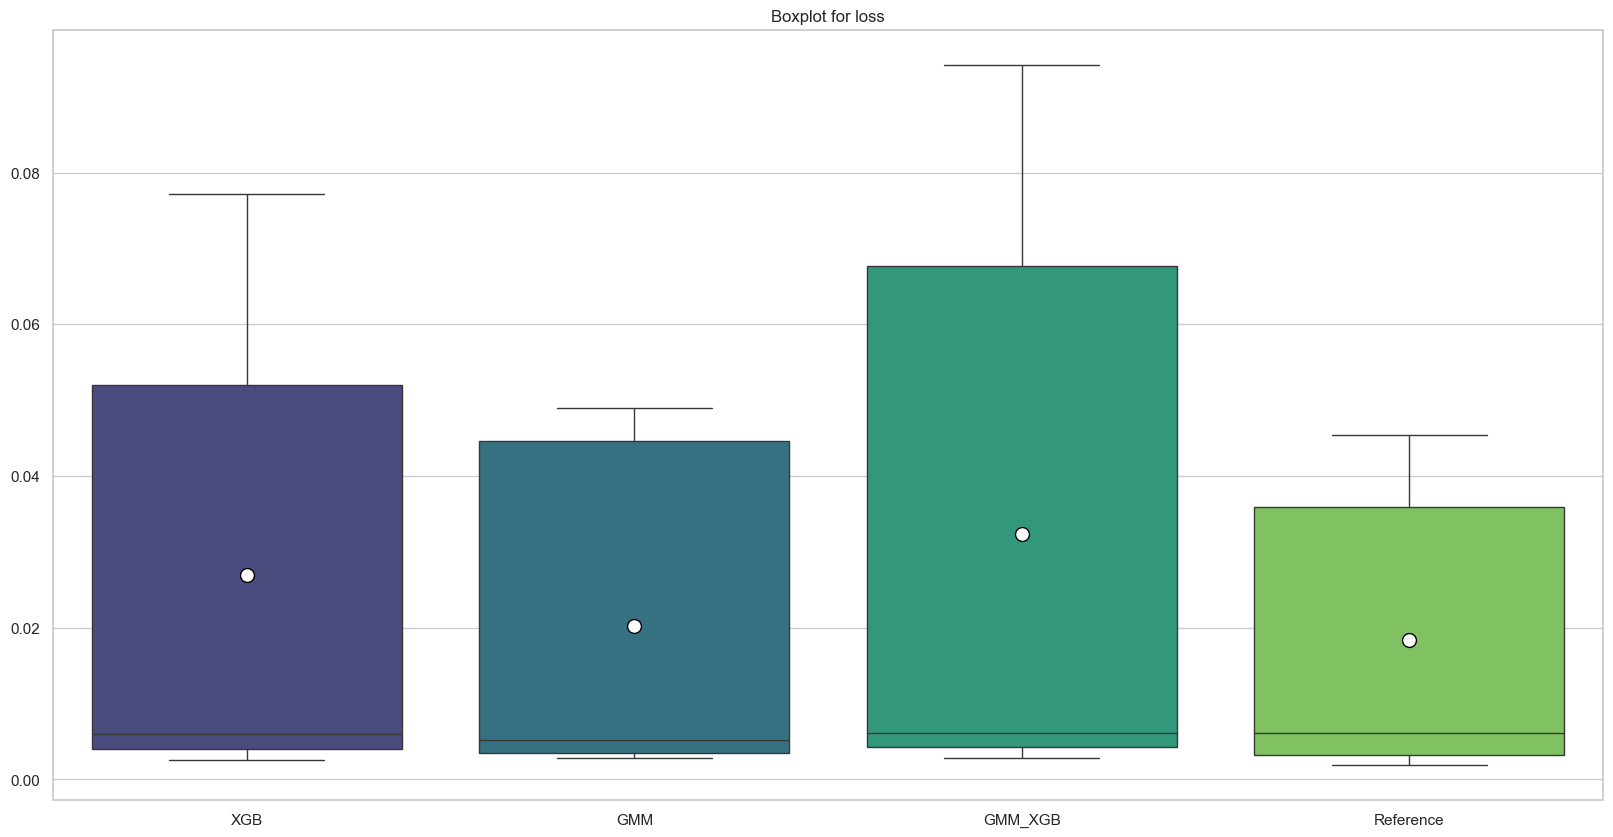

In [ ]:
#boxplot for loss
import seaborn as sns
plt.figure(figsize=(20, 10))
#setting the style
sns.set(style='whitegrid')
sns.boxplot(data=loss_comparison, palette='viridis',
            showmeans=True, meanprops={"marker":"o",
                                        "markerfacecolor":"white", 
                                        "markeredgecolor":"black",
                                        "markersize":"10"})

plt.title('Boxplot for loss')
plt.show()

In [ ]:
#performing an anova test
import scipy.stats as stats
fvalue, pvalue = stats.f_oneway(xgb_loss_per_fold, gmm_loss_per_fold, gmm_xgb_loss_per_fold, ref_loss_per_fold)
print(f'F-value: {fvalue}, p-value: {pvalue}')

F-value: 0.520863185990717, p-value: 0.6706524005385914


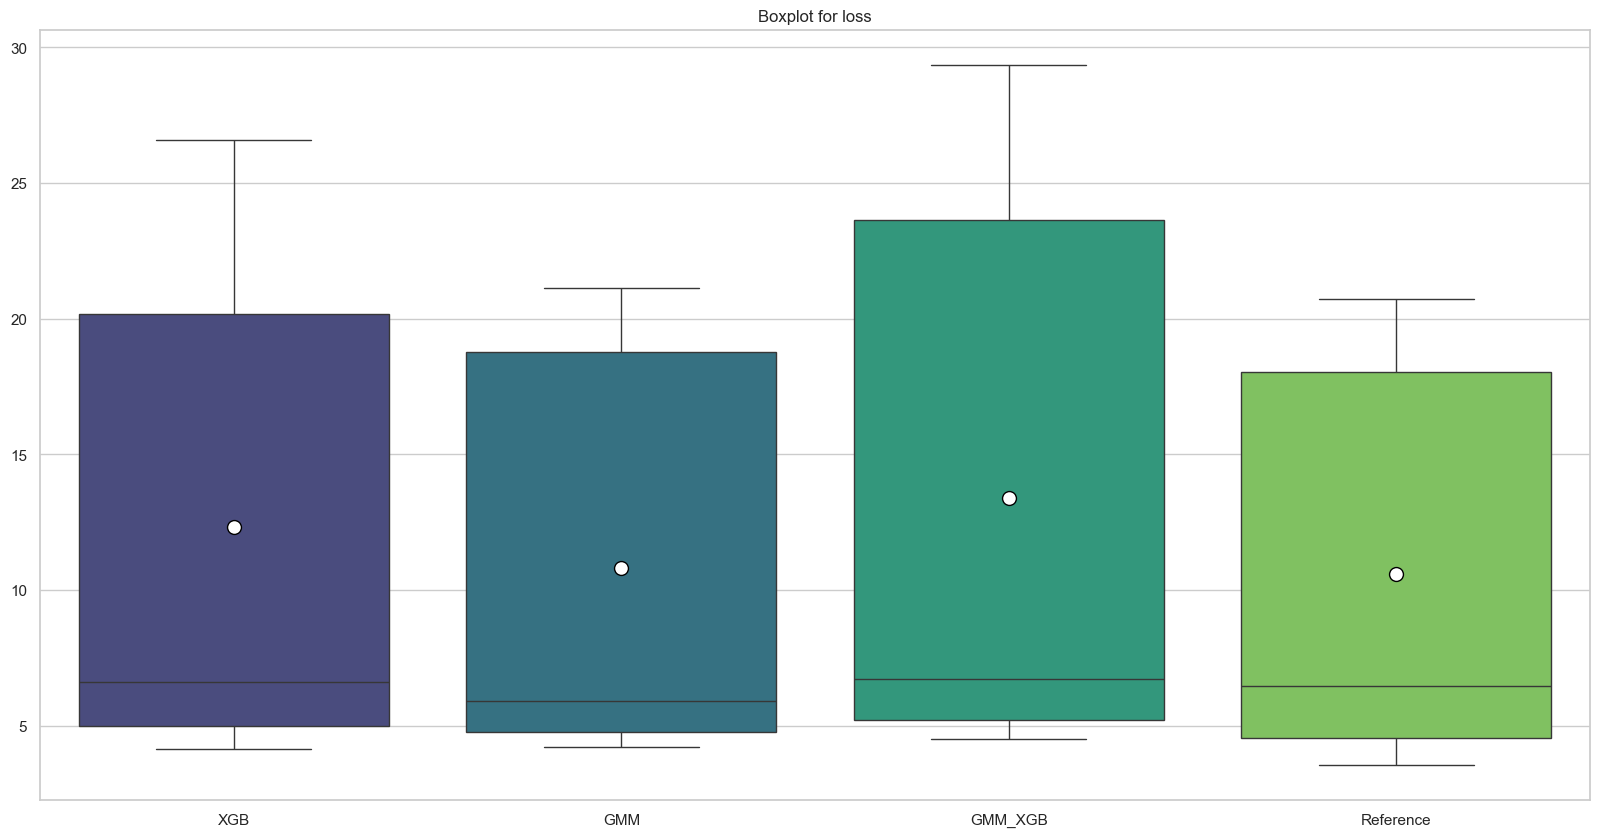

In [ ]:
#boxplot for loss
import seaborn as sns
plt.figure(figsize=(20, 10))
#setting the style
sns.set(style='whitegrid')
sns.boxplot(data=acc_comparison, palette='viridis',
            showmeans=True, meanprops={"marker":"o",
                                        "markerfacecolor":"white", 
                                        "markeredgecolor":"black",
                                        "markersize":"10"})

plt.title('Boxplot for loss')
plt.show()

In [ ]:
import scipy.stats as stats
fvalue, pvalue = stats.f_oneway(xgb_acc_per_fold, gmm_acc_per_fold,  gmm_xgb_acc_per_fold,  ref_acc_per_fold)
print(f'F-value: {fvalue}, p-value: {pvalue}')

F-value: 0.23183769413425492, p-value: 0.8735983008529312


In [ ]:
#power analysis
import statsmodels.stats.power as smp

# Parameters
effect_size = 0.5 # assumed effect size
alpha = 0.05        # significance level
power = 0.8         # desired power
num_groups = 4      # number of groups in ANOVA

# Initialize power analysis object for ANOVA
analysis = smp.FTestAnovaPower()

# Calculate sample size
sample_size = analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, k_groups=num_groups)
print(f"Required sample size per group: {sample_size:.2f}")

Required sample size per group: 47.70
